# Embedding and KNN

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsRegressor
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras import layers, models, Sequential, Input, Model
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.data.experimental import cardinality
from tensorflow.data.experimental import AUTOTUNE
from tensorflow.keras.models import load_model
import joblib

## Load CNN model

In [2]:
model = load_model('../models/Full_training/20201212_205911_VGG16_v3_27/')
model.summary()

Model: "functional_53"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_54 (InputLayer)        [(None, 224, 224, 3)]     0         
_________________________________________________________________
tf_op_layer_strided_slice_26 (None, 224, 224, 3)       0         
_________________________________________________________________
tf_op_layer_BiasAdd_26 (Tens (None, 224, 224, 3)       0         
_________________________________________________________________
sequential_52 (Sequential)   (None, 400)               24750288  
_________________________________________________________________
dense_53 (Dense)             (None, 12)                4812      
Total params: 24,755,100
Trainable params: 24,755,100
Non-trainable params: 0
_________________________________________________________________


## Embedding calculation of images DB

In [3]:
BATCH_SIZE = 32
IMG_SIZE = (224, 224)

In [4]:
%%time
layer_outputs = [model.layers[-1].input]
embedding_model = models.Model(inputs=model.input, outputs=layer_outputs)

test_dir = r'C:\Users\pitip\OneDrive\Bureau\raw_data\Clean_Data\Test'
img_list = []
for dir_path in os.listdir(test_dir):
    img_list += os.listdir(os.path.join(test_dir, dir_path))
#for root, dirs, files in os.walk(test_dir, topdown=True):
#    for name in files:
#        img_list.append(os.path.join(name))
test_dataset = image_dataset_from_directory(test_dir, shuffle=False, batch_size=BATCH_SIZE, image_size=IMG_SIZE, label_mode='int', 
                                             labels=img_list, interpolation='bilinear')

image_embeddings = embedding_model.predict(test_dataset)
image_embeddings.shape

Found 1390 files belonging to 12 classes.
Wall time: 5min 31s


(1390, 400)

## Fit KNN Regressor on embeddings

In [5]:
knr = KNeighborsRegressor(n_neighbors=5)
knr.fit(image_embeddings, img_list)

KNeighborsRegressor()

## KNN Regressor prediction

In [6]:
test_dir_imext = r'C:\Users\pitip\OneDrive\Bureau\raw_data\Donnees_tests\Données tests\Picasso'
img_list_imext =os.listdir(test_dir_imext+'\_1')
test_dataset_imext = image_dataset_from_directory(test_dir_imext, shuffle=False, batch_size=BATCH_SIZE, image_size=IMG_SIZE, label_mode='int', 
                                             labels=img_list_imext, interpolation='bilinear')


print(img_list_imext)
image_embeddings_imext = embedding_model.predict(test_dataset_imext)
image_embeddings_imext.shape

Found 7 files belonging to 1 classes.
['32688_xl.jpg', '711K+aMaSGL._AC_SX466_.jpg', '71L7b+wAQkL._AC_SL1000_.jpg', 'Detournement-Femme-livre-Pablo-Picasso-publicite-812x700.jpg', 'images.jpg', 'STVLCRTKQGOJWUKAV5JFAI77GA.jpg', 'tableaux-sur-toile-le-reve-de-pablo-picasso.jpg']


(7, 400)

In [7]:
for i in range(len(img_list_imext)):
    out = knr.kneighbors(X=image_embeddings_imext[i,:].reshape(1, -1), n_neighbors=3, return_distance=True)
    print(out)

(array([[4.51133326, 5.28040534, 5.36800395]]), array([[643, 652, 677]], dtype=int64))
(array([[4.15722243, 4.25172595, 4.45082292]]), array([[637, 631, 666]], dtype=int64))
(array([[2.79775826, 4.23555512, 4.33966001]]), array([[677, 682, 723]], dtype=int64))
(array([[3.63603452, 3.7071584 , 4.09154649]]), array([[652, 723, 682]], dtype=int64))
(array([[4.82890788, 4.86837666, 5.00527522]]), array([[637, 121, 648]], dtype=int64))
(array([[4.49710667, 4.76041028, 4.7932105 ]]), array([[210, 643, 683]], dtype=int64))
(array([[5.28895322, 5.59674323, 5.60082465]]), array([[677, 125, 138]], dtype=int64))


[array([[643, 652, 677]], dtype=int64),
 array([[637, 631, 666]], dtype=int64),
 array([[677, 682, 723]], dtype=int64),
 array([[652, 723, 682]], dtype=int64),
 array([[637, 121, 648]], dtype=int64),
 array([[210, 643, 683]], dtype=int64),
 array([[677, 125, 138]], dtype=int64)]

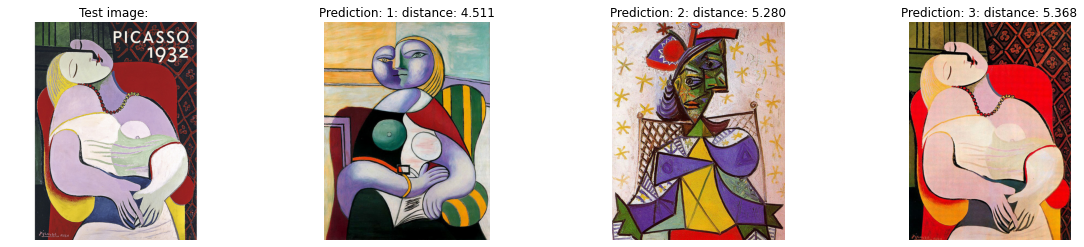

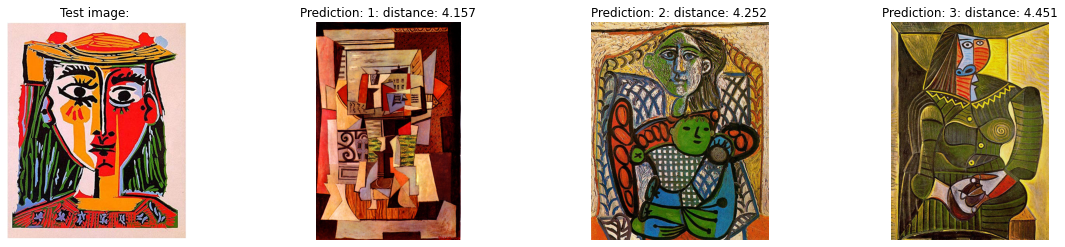

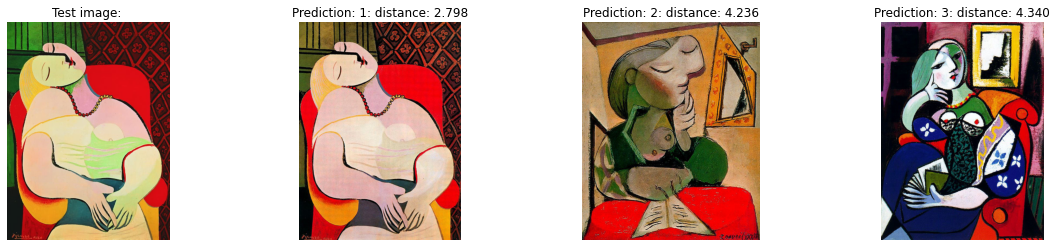

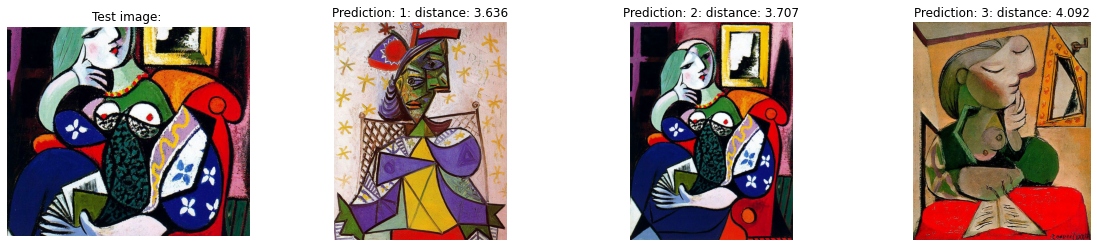

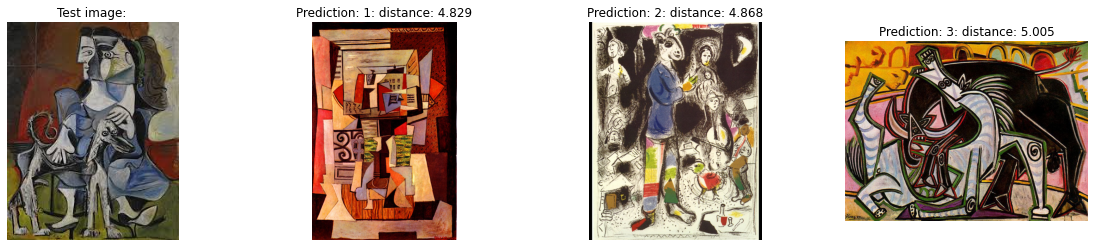

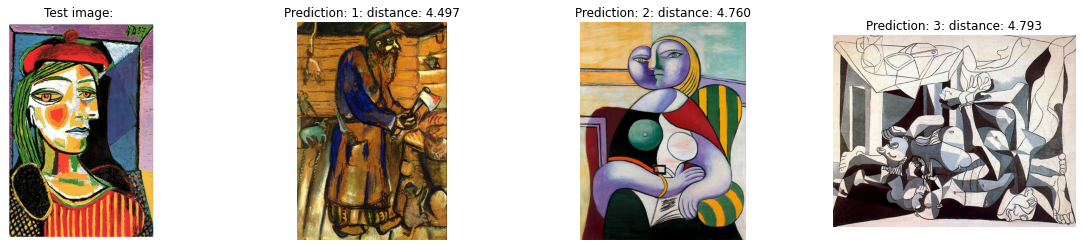

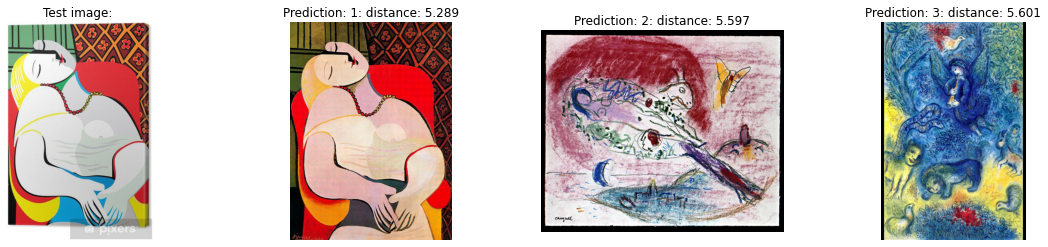

In [8]:
predict_image = []
predict_dist = []
for j in range(len(img_list_imext)):
    fig, ax = plt.subplots(1, 4, figsize=(20,4))
    img = plt.imread(os.path.join(test_dir_imext, '_1', img_list_imext[j]))
    ax[0].imshow(img)
    ax[0].axis('off')
    ax[0].set_title('Test image: ')
    
    dist, pred_label = knr.kneighbors(X=image_embeddings_imext[j,:].reshape(1, -1), n_neighbors=3, return_distance=True)
    predict_image.append(pred_label)
    predict_dist.append(dist)
    for i in range(3):
        for k in range(1, 13):
            path_img = os.path.join(test_dir, f"_{k}", img_list[pred_label[0][i]])
            if os.path.isfile(path_img):
                img = plt.imread(os.path.join(test_dir, '_1', path_img))
                ax[i+1].imshow(img)
                ax[i+1].axis('off')
        ax[i+1].set_title(f'Prediction: {i+1}: distance: {dist[0][i]:.3f}')
predict_image

In [9]:
predict_image

[array([[643, 652, 677]], dtype=int64),
 array([[637, 631, 666]], dtype=int64),
 array([[677, 682, 723]], dtype=int64),
 array([[652, 723, 682]], dtype=int64),
 array([[637, 121, 648]], dtype=int64),
 array([[210, 643, 683]], dtype=int64),
 array([[677, 125, 138]], dtype=int64)]

In [10]:
img_list[predict_image[0][0][0]]

'38305.jpg'

## Save model and reload

In [11]:
joblib.dump(knr, '../models/KNN_models/model1.joblib')

['../models/KNN_models/model1.joblib']

[array([[643, 652, 677]], dtype=int64),
 array([[637, 631, 666]], dtype=int64),
 array([[677, 682, 723]], dtype=int64),
 array([[652, 723, 682]], dtype=int64),
 array([[637, 121, 648]], dtype=int64),
 array([[210, 643, 683]], dtype=int64),
 array([[677, 125, 138]], dtype=int64)]

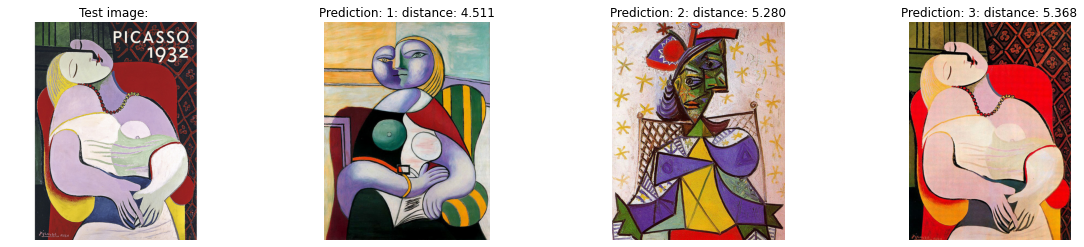

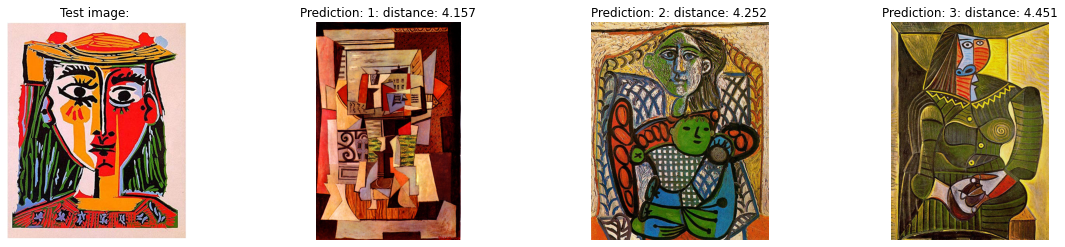

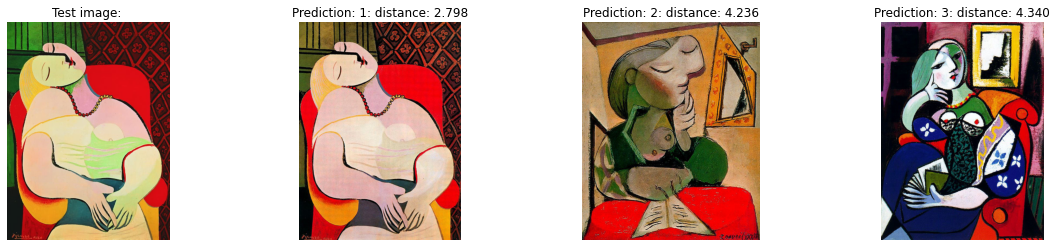

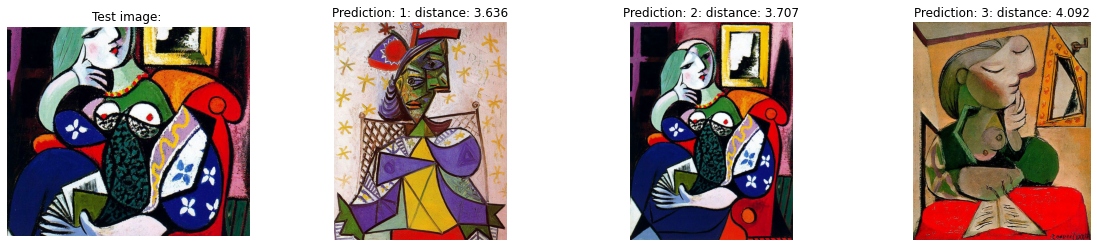

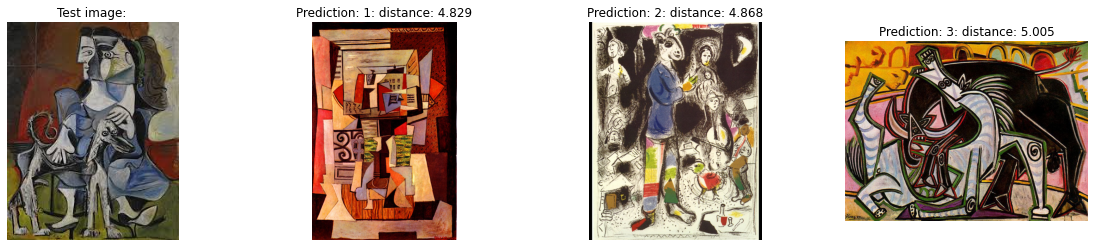

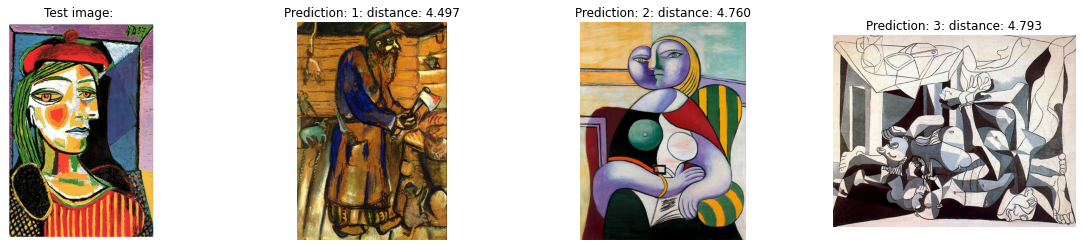

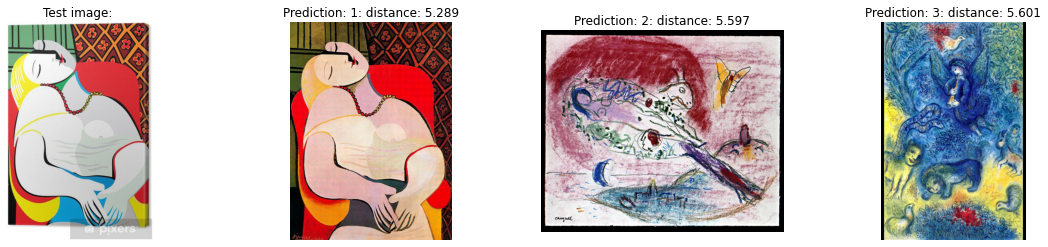

In [12]:
loaded_knr = joblib.load('../models/KNN_models/model1.joblib')
predict_image = []
predict_dist = []
for j in range(len(img_list_imext)):
    fig, ax = plt.subplots(1, 4, figsize=(20,4))
    img = plt.imread(os.path.join(test_dir_imext, '_1', img_list_imext[j]))
    ax[0].imshow(img)
    ax[0].axis('off')
    ax[0].set_title('Test image: ')
    
    dist, pred_label = loaded_knr.kneighbors(X=image_embeddings_imext[j,:].reshape(1, -1), n_neighbors=3, return_distance=True)
    predict_image.append(pred_label)
    predict_dist.append(dist)
    for i in range(3):
        for k in range(1, 13):
            path_img = os.path.join(test_dir, f"_{k}", img_list[pred_label[0][i]])
            if os.path.isfile(path_img):
                img = plt.imread(os.path.join(test_dir, '_1', path_img))
                ax[i+1].imshow(img)
                ax[i+1].axis('off')
        ax[i+1].set_title(f'Prediction: {i+1}: distance: {dist[0][i]:.3f}')
predict_image